In [316]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

In [317]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [318]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'YEAR', 'QUARTER', 'NAMEADDR']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    permits = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_STATUS_DATE'])
    permits = permits.drop_duplicates()
    permits = permits.set_index('PERMIT_ID')
    
    X = pd.read_csv("data_complete/Building_Permits_ISSUED.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_ISSUED_DATE'])
    X = X.drop_duplicates()
    X = X.set_index('PERMIT_ID')
    X.rename(columns = {'PERMIT_ISSUED_DATE':'PERMIT_DATE'}, inplace = True)
    return X, permits

permits, more_permits = loadPermits()
    
df = loadData()
df = df[columns]
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df.head()
permits.count()

PERMIT_DATE    344941
dtype: int64

In [319]:
permits = permits.join(more_permits, how='inner')

# keep only first and last entry for each building
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="first")
construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="last")

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))

data = data[~data.duplicated('PERMIT_ID')]
data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

# Duration = last 'construction' entry year/quarter - permit issue year/quarter in quarters
data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'NAMEADDR',# , 'PERMIT_DATE', 'YEAR_START', 'QUARTER_START'
             'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'COST', 'PERMIT_TYPE']]#, 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data['COST'] = data['COST'].fillna(data['COST'].mean()).astype('int64')
data.groupby(['PERMIT_TYPE']).count()

565
679


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,COST
PERMIT_TYPE,,,,,,,,,
additions alterations or repairs,294,294,294,294,294,294,294,294,294
new construction,101,101,101,101,101,101,101,101,101
new construction wood frame,280,280,280,280,280,280,280,280,280
otc alterations permit,4,4,4,4,4,4,4,4,4


In [320]:
# Split completed by 2017Q1 and still in construction by 2017Q1
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]

print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())

Completed by 2017:  464
Still in construction by 2017:  215


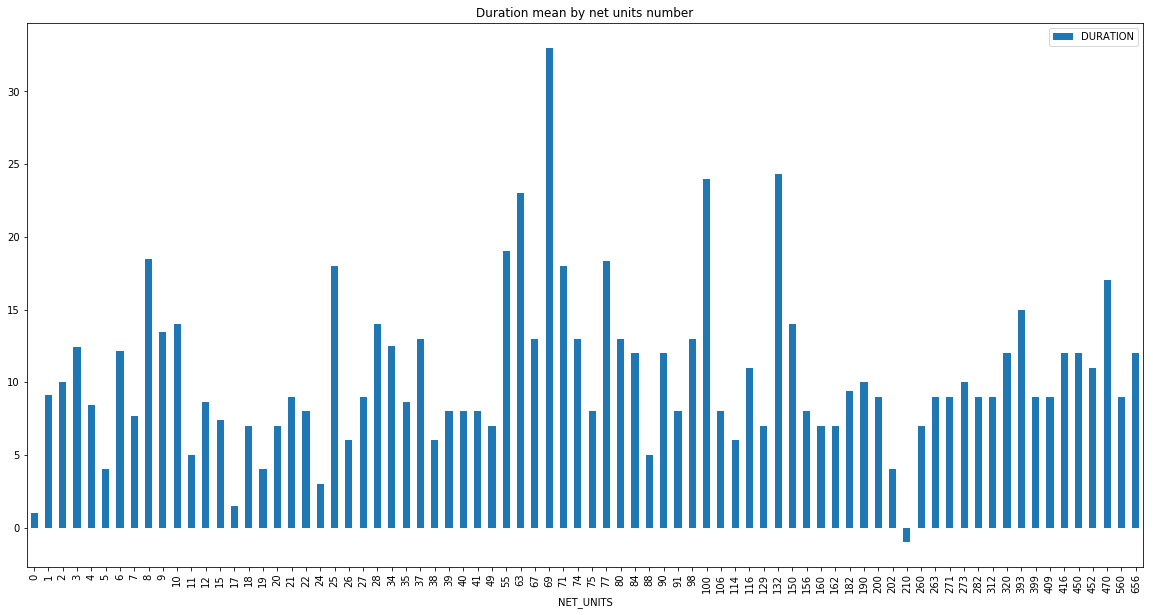

In [321]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10), title = "Duration mean by net units number")

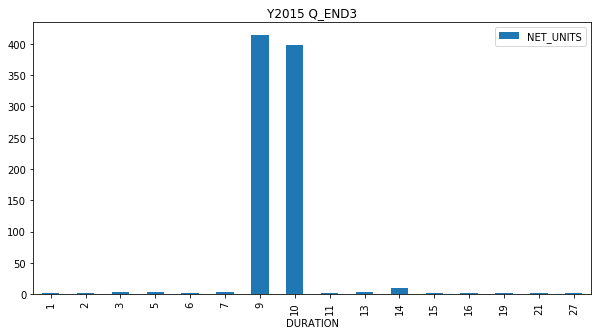

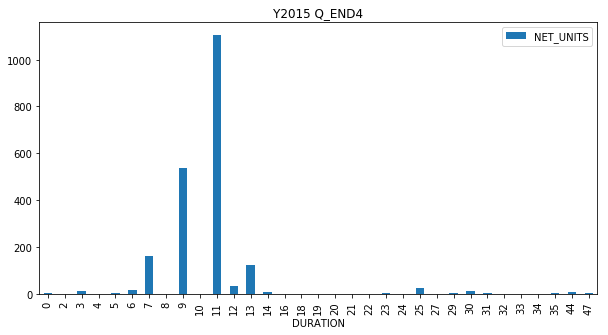

In [322]:
def plot_duration(year, quarter_end):
    d1 = complete[(complete['YEAR_END'] == year) & (complete['QUARTER_END'] == quarter_end)]
    grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(10,5), title = "Y" + str(year) + " Q_END" + str(quarter_end))

#plot_duration(2015, 1)
#plot_duration(2015, 2)
plot_duration(2015, 3)
plot_duration(2015, 4)

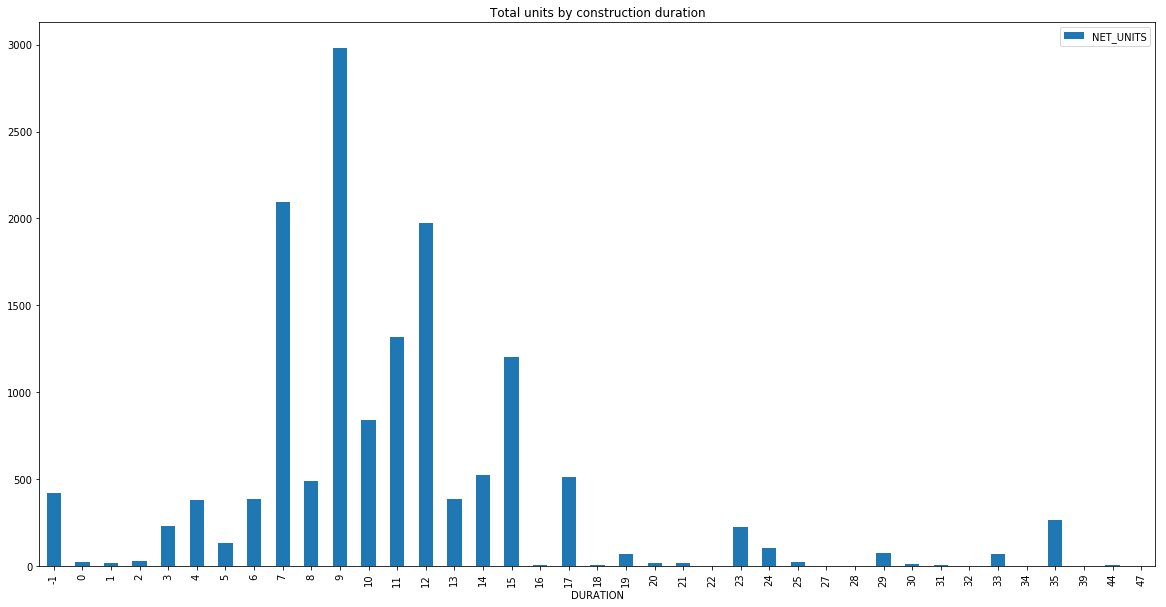

In [323]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Total units by construction duration")

In [324]:
def mean_std_norm(column):
    return (column - column.mean()) / column.std()

def min_max_norm(column):
    return (column - column.min())/(column.max() - column.min())

result = incomplete.copy()

complete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(complete['PERMIT_DATE_YEAR'])
incomplete['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(incomplete['PERMIT_DATE_YEAR'])

complete['UNITS_NORM'] = mean_std_norm(complete['UNITS'])
incomplete['UNITS_NORM'] = mean_std_norm(incomplete['UNITS'])

complete['NET_UNITS_NORM'] = mean_std_norm(complete['NET_UNITS'])
incomplete['NET_UNITS_NORM'] = mean_std_norm(incomplete['NET_UNITS'])

complete['COST_NORM'] = mean_std_norm(complete['COST'])
incomplete['COST_NORM'] = mean_std_norm(incomplete['COST'])


columns_to_show = ['NAMEADDR', 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'DURATION_PREDICTED', 
                   'YEAR_END', 'QUARTER_END' ,'COST']

In [325]:
display(permits.head())
permits = permits[(permits["PERMIT_TYPE"] == "new construction wood frame") | 
                  (permits["PERMIT_TYPE"] == "new construction") |
                  (permits["PERMIT_TYPE"] == "additions alterations or repairs")].reset_index()
permits = permits[(permits['PERMIT_STATUS'] == 'issued') & (permits['NET_UNITS_'] > 0) & (permits['NET_UNITS_'] < 800)]

permits['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(permits['PERMIT_DATE']).year
permits['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(permits['PERMIT_DATE']).quarter

permits['PERMIT_DATE_YEAR_NORM'] = mean_std_norm(permits['PERMIT_DATE_YEAR'])

permits['UNITS_NORM'] = mean_std_norm(permits['UNITS_'])

permits['NET_UNITS_NORM'] = mean_std_norm(permits['NET_UNITS_'])

permits['COST'] = permits['COST'].fillna(permits['COST'].mean()).astype('int64')
permits['COST_NORM'] = mean_std_norm(permits['COST'])

permits[['UNITS', 'NET_UNITS']] = permits[['UNITS_', 'NET_UNITS_']].astype('int64')


#permits.sort_values(['NET_UNITS_'], ascending=False)

,PERMIT_DATE,PERMIT_STATUS_DATE,PERMIT_STATUS,COST,PERMIT_TYPE,UNITS_BEFORE_,UNITS_,NAMEADDR_,NET_UNITS_
PERMIT_ID,,,,,,,,,
N20000109571,2006-08-29,12/08/2008,complete,506000.0,new construction wood frame,0.0,2.0,Benton Ave 360,2.0
N20000112863,2006-08-29,12/08/2008,complete,506000.0,new construction wood frame,0.0,2.0,Benton Ave 340,2.0
N20000112900,2004-08-31,08/31/2004,issued,NaN,demolitions,2.0,0.0,Kirkham St 507,-2.0
N20000112900,2004-08-31,08/31/2004,issued,NaN,demolitions,2.0,0.0,Kirkham St 505,-2.0
N20000112908,2004-08-31,11/15/2005,complete,438000.0,new construction wood frame,0.0,2.0,Kirkham St 505,2.0


In [326]:
X_train, X_val, y_train, y_val = train_test_split(
    complete, 
    complete['DURATION'], 
    test_size=0.3) 

train_columns = ['NET_UNITS_NORM', 'PERMIT_DATE_YEAR_NORM', 'PERMIT_DATE_QUARTER', 'COST_NORM', 'UNITS_NORM']

def plot_diffs(pred, act):
    fig = plt.figure() # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    width = 0.4

    pred.plot(y = 'NET_UNITS', kind='bar', color='red', ax=ax, width=width, position=1)
    act.plot(y = 'NET_UNITS', kind='bar', color='blue', ax=ax2, width=width, position=0)
    ax.set_ylabel('Total Net Units')
        
def train(model):
    return model.fit(X_train[train_columns], y_train)

def validate(model):
    print("Validation on historical data:")
    y_val_predicted = model.predict(X_val[train_columns])
    X_val['DURATION_PREDICTED'] = np.ceil(y_val_predicted)
    X_val['YEAR_END_PREDICTED'] = np.floor(X_val['PERMIT_DATE_YEAR'] + (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) / 4)
    X_val['QUARTER_END_PREDICTED'] = (X_val['PERMIT_DATE_QUARTER'] + X_val['DURATION_PREDICTED']) % 4 + 1
    
    pred_sum = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum()
    act_sum = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].sum()
    plot_diffs(pred_sum, act_sum)    
    
    #pred_mean = X_val.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].mean()
    #act_mean = X_val.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].mean()
    #plot_diffs(pred_mean, act_mean)
    
    # prediction error
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_val_predicted))
    
    display(X_val[columns_to_show].sort_values(by=['NET_UNITS'],ascending=False).head(15))
    
def predict_with_model(model):
    print("Prediction for not completed buildings:")
    duration_predicted = model.predict(incomplete[train_columns])
    result['DURATION_PREDICTED'] = np.ceil(duration_predicted).astype('int64')
    result['QUARTERS_LEFT'] = (result['DURATION_PREDICTED'] - result['DURATION']).astype('int64')
    result['YEAR_END_PREDICTED'] = np.floor(result['PERMIT_DATE_YEAR'] + 
                                            (result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) / 4
                                           ).astype('int64')
    result['QUARTER_END_PREDICTED'] = ((result['PERMIT_DATE_QUARTER'] + result['DURATION_PREDICTED']) % 4 + 1).astype('int64')

    prediction = result[columns_to_show + ['QUARTERS_LEFT']].sort_values(['YEAR_END_PREDICTED', 'NET_UNITS'], ascending=[True, False]).reset_index().drop_duplicates(subset=['PERMIT_ID'], keep="first")
    prediction.to_csv("data_complete/predictions.csv")
    
    grouped = prediction.sort_values(['NET_UNITS']).groupby(['QUARTERS_LEFT']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Net units deliv  ered by quarters left")
    
    display(prediction.head(30))
    return prediction

In [327]:
# with random forest

#model = train(RandomForestRegressor(n_estimators=8, max_depth=6, criterion="mse", min_samples_split=6))
#print('Feature importances: \n', model.feature_importances_)
#validate(model)

Validation on historical data:
Mean squared error: 25.69


,NAMEADDR,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,COST
PERMIT_ID,,,,,,,,,,,,
N201207124717,201 FOLSOM ST,2016.0,3.0,656,656,2013,2,12,12.0,2016,1,110545000
N201307303137,350 08TH ST,2016.0,1.0,416,416,2014,1,12,7.0,2016,4,123000000
N201208026344,100 VAN NESS AV,2015.0,2.0,399,399,2012,4,9,9.0,2014,4,75000000
N201112070234,1006 / 1050 16TH ST & 1380 07TH ST,2015.0,1.0,393,393,2012,3,15,9.0,2016,1,98068000
N201112070234,1006 / 1050 16TH ST & 1380 07TH ST,2015.0,1.0,393,393,2012,3,15,9.0,2016,1,98068000
N201112070234,1006 / 1050 16TH ST & 1380 07TH ST,2015.0,1.0,393,393,2012,3,15,9.0,2016,1,98068000
N201106017208,900 Folsom St,2015.0,1.0,282,282,2012,3,9,9.0,2014,3,76510000
N201209119428,800 Brotherhood Way,2017.0,4.0,210,210,2015,4,-1,7.0,2015,2,864288
N201409116118,1095 MARKET ST,2017.0,4.0,202,202,2015,4,4,7.0,2016,3,14000000


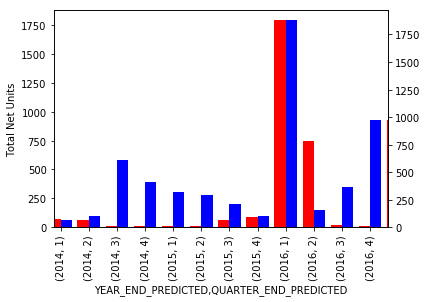

In [328]:
model = train(MLPClassifier(hidden_layer_sizes=(20), random_state=1))
#print('Coefficients: \n', model.coef_)
validate(model)

Prediction for not completed buildings:


,PERMIT_ID,NAMEADDR,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,DURATION_PREDICTED,YEAR_END,QUARTER_END,COST,QUARTERS_LEFT
0,N201305015894,181 FREMONT ST,2015,4,140,140,2013,4,14,7,2017,1,136313594,-7
2,N200910209343,202 BROAD ST,2015,4,2,2,2014,3,11,4,2017,1,700000,-7
3,N200910209344,200 BROAD ST,2015,4,2,2,2014,3,11,4,2017,1,750000,-7
6,N201302250862,1451 MARIPOSA ST,2015,3,3,1,2014,2,12,4,2017,1,66000,-8
7,N201305156961,546 34TH AV,2015,4,2,1,2014,3,11,4,2017,1,1080000,-7
8,N201310119147,1302 YORK ST,2015,4,3,1,2014,3,11,4,2017,1,68000,-7
10,N201209069080,TRINITY PLAZA,2016,2,550,550,2013,4,14,9,2017,1,133333000,-5
11,N201305036062,555 FULTON ST,2016,1,139,139,2014,1,13,7,2017,1,48723500,-6
13,N201204168406,800 PRESIDIO AV,2016,4,83,83,2014,2,12,9,2017,1,15000000,-3
14,N200602023710,570 JESSIE ST,2016,1,47,47,2015,1,9,3,2017,1,7000000,-6


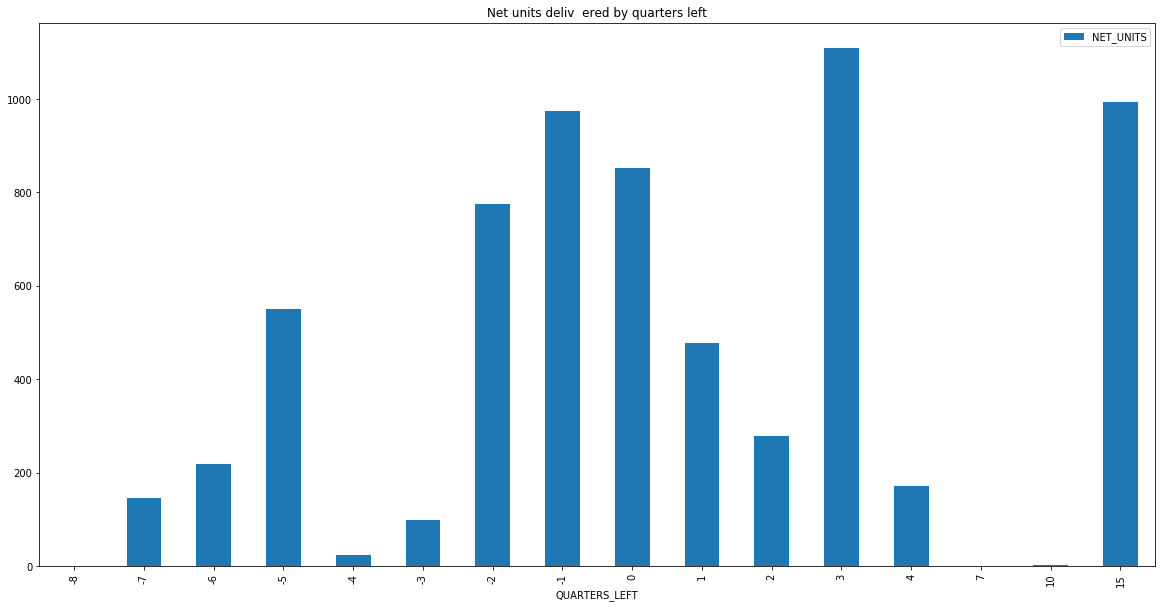

In [329]:
prediction = predict_with_model(model)

In [330]:
columns_to_show = ['PERMIT_ID', 'NAMEADDR_', 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION_PREDICTED', 
                   'COST']

duration_predicted = model.predict(permits[train_columns])
permits['DURATION_PREDICTED'] = np.ceil(duration_predicted).astype('int64')
permits['YEAR_END_PREDICTED'] = np.floor(permits['PERMIT_DATE_YEAR'] + 
                                         (permits['PERMIT_DATE_QUARTER'] + permits['DURATION_PREDICTED']) / 4
                                        ).astype('int64')
permits['QUARTER_END_PREDICTED'] = ((permits['PERMIT_DATE_QUARTER'] + permits['DURATION_PREDICTED']) % 4 + 1).astype('int64')
permits = permits[columns_to_show]
permits.to_csv("data_complete/issued_predictions.csv")
permits = permits.sort_values(['YEAR_END_PREDICTED', 'NET_UNITS'], ascending=[True, False]).drop_duplicates(subset=['PERMIT_ID'], keep="first")
display(permits.head(30))
permits.to_csv("data_complete/issued_predictions.csv")

,PERMIT_ID,NAMEADDR_,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION_PREDICTED,COST
14337,N200606144063,09th St 66,2011,1,107,107,2007,2,14,28000000
12290,N200512281145,Executive Park Blvd 101,2011,2,98,98,2007,3,14,35181000
9820,N200506084563,Battery St 810,2011,2,81,81,2005,4,21,325000
744,N200305124383,Market St 1005,2011,2,42,42,2005,4,21,1
10884,N200509022013,Divisadero St 914,2011,2,2,2,2005,4,21,195000
1452,N200310167584,20th St 3676,2011,2,2,1,2005,4,21,300000
3786,N200404141320,45th Ave 1359,2011,2,2,1,2005,4,21,300000
4826,N200406116191,22nd St 1919,2011,2,2,1,2005,4,21,512000
5395,N200407209286,York St 721,2011,2,2,1,2005,4,21,102400
7367,N200412161603,Tehama St 431,2011,2,1,1,2005,4,21,287000


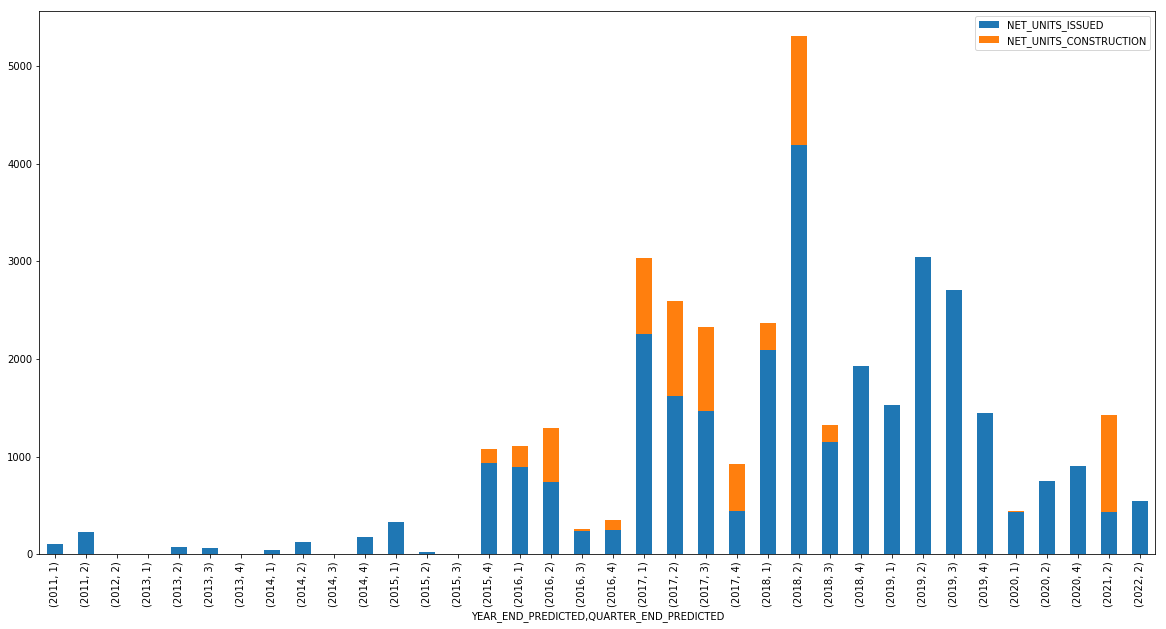

In [331]:
def plot_quarters(df):
    df.plot.bar(stacked=True, figsize=(20,10));

issued_sum = permits.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum().reset_index()
construction_sum = prediction.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum().reset_index()

df_sum = pd.merge(issued_sum, construction_sum, how='outer', on=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'], 
                  left_on=None, right_on=None, suffixes=('_ISSUED', '_CONSTRUCTION'))

plot_quarters(df_sum.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']).sum())

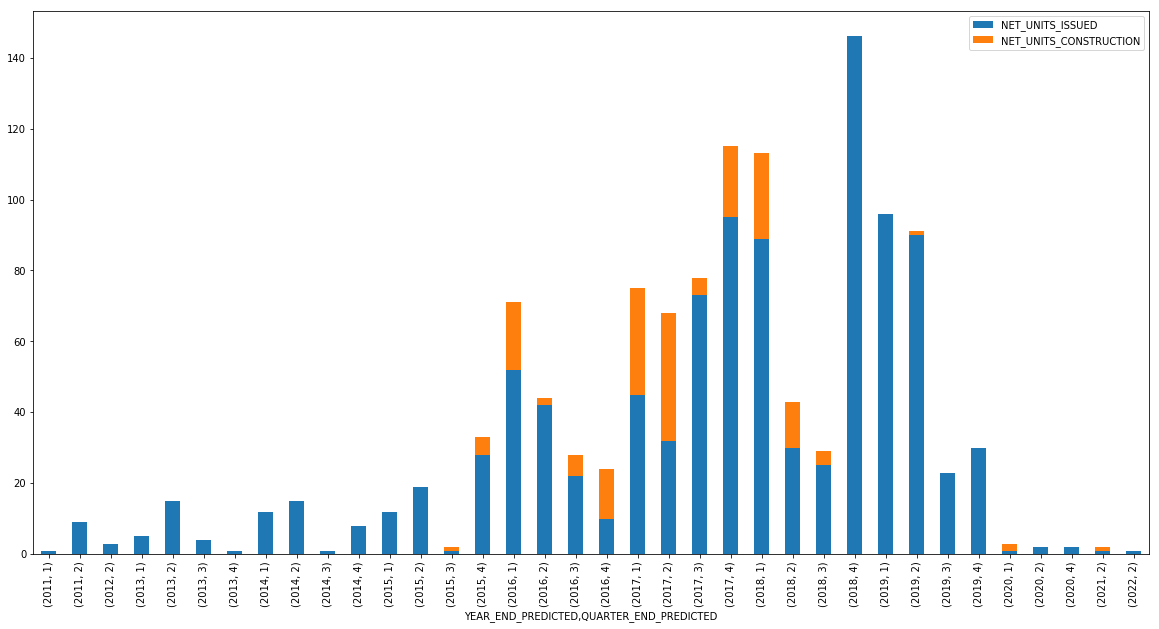

In [332]:
issued_count = permits.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].count().reset_index()
construction_count = prediction.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].count().reset_index()

df_count = pd.merge(issued_count, construction_count, how='outer', on=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'], 
                  left_on=None, right_on=None, suffixes=('_ISSUED', '_CONSTRUCTION'))

plot_quarters(df_count.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']).sum())

In [275]:
# with linear regression

#model = train(linear_model.LinearRegression(fit_intercept=True, normalize=False))
#print('Coefficients: \n', model.coef_)
#validate(model)

In [274]:
#predict_with_model(model)